In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# a) residence time v.s. chiPN & gamma, monomer

In [4]:
parm_ana = GenParameters(
    numTargets=2, KPN=np.logspace(1, 3, 5+2*40)*2.0, 
    NP0=[0.1], KPP=[np.inf], area3Dto1D=[1, 100],
)
parm_num_m = GenParameters(
    numTargets=2, KPN=np.logspace(1, 3, 5+2*0)*2.0, 
    NP0=[0.1], KPP=[0], area3Dto1D=[1, 100],
)
numSize = parm_num_m.shape[0]

In [5]:
def calc_tauB_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    kaStokaN = parms['kaPS']/parms['kaPN']
    CS0toCN0 = parms['CS0']/parms['CN0']
    tauN = 1/parms['kbPN']
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+kaStokaN*CS0toCN0)*tauN

resT_B_m = calc_tauB_m(parm_ana)

equi_num_m = numericSolver(parm_df=parm_num_m, labels=labelsSingleS, model=rxnSingleS)
resT_num_m = np.zeros(numSize)

for iloc in range(numSize):
    resT_num_m[iloc] = num.calc_resT_modelB(parm_num_m.iloc[iloc], equi_num_m.iloc[iloc])

2024-10-29 15:54:18.523728
Number of cores used:  10/36
Finished parallel processing.


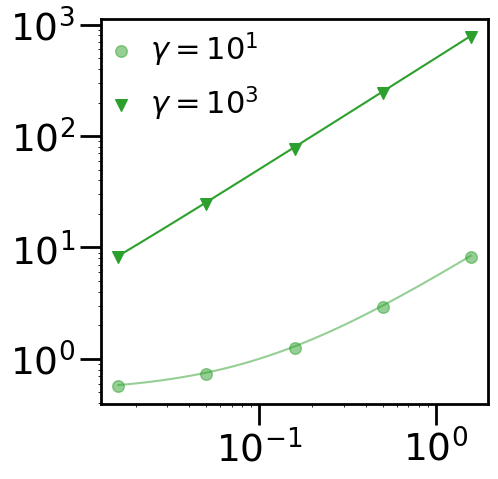

In [9]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.7], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
color_gamma = 'tab:green'
gamList = np.unique(parm_ana['gamma'])
alphas = [0.5, 1]
markers = ['o','v']
for i, gam in enumerate(gamList):
    selected = (parm_ana['gamma']==gam)
    selected_num = (parm_num_m['gamma']==gam)
    # analytical
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        (resT_B_m*parm_ana['kbPS'])[selected],
        color=color_gamma, alpha=alphas[i]
    )
    # numerical
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected],
        (resT_num_m*parm_num_m['kbPS'])[selected],
        color=color_gamma, alpha=alphas[i], s=70,
        marker=markers[i], label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
ax.loglog()
# plt.ylim([0.9e2, 3e4])
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_MONOMER.png', transparent=True)

# extra) distribution of residence time

In [4]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 1000*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[32], kbPP_fixed=kbP,
    KPP=[0, 1e2, 1e6],
)

In [7]:
parm_num = GenParms(1e-2, 0)

equi_num = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

2024-12-30 16:40:29.409830
Number of cores used:  3/36
Finished parallel processing.


In [8]:
from pathlib import Path

pdir = '../Simulations/Gillespie/DNAtarg:criticDimer//'
Path(pdir).mkdir(parents=True, exist_ok=True)
parm_num.to_csv(pdir+'/parameters.csv')
equi_num.to_csv(pdir+'/equilibrium.csv')

# b) residence time v.s. KPP & C0, dimer, model B

In [1]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    onRate = (kbPS*chiS + kbPN*chiN)
    return (onRate*gamma*chiN*2)/(1 + gamma*chiN)/chiS

In [11]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 1000*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=[32], # area3Dto1D was 35 in figure plots, I changed this for a k^* closer to 0.01
    KPP=np.logspace(1,9,8+7*nDenseKPP), kbPP_fixed=kbP   
)

parm_num = pd.concat([GenParms(1e-3, 0), GenParms(1e-2, 0), GenParms(1e-1, 0)], axis=0)
parm_ana = pd.concat([GenParms(1e-3, 10), GenParms(1e-2, 10), GenParms(1e-1, 10)], axis=0)

In [12]:
np.unique(criticalRate(parm_num)), np.unique(criticalRate_approx(parm_num))

(array([0.01000451]), array([0.01001714]))

In [13]:
parm_num['gamma'].unique()*parm_num['kaPN'].unique()*0.6022, parm_num['CP0'].unique()/0.6022

(array([3763.75]), array([7.90751372e-06]))

In [14]:
resTs = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    parm = parm_ana.iloc[iloc]
    resTs[iloc] = ana.ana_resTime_balance(parm, numClusterS=1)

In [15]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

2024-12-30 15:32:54.709740
Number of cores used:  24/36
Finished parallel processing.


In [16]:
resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    resT_num_rev[iloc] = num.calc_resT_modelB(parm_num.iloc[iloc], equi_num_rev.iloc[iloc])

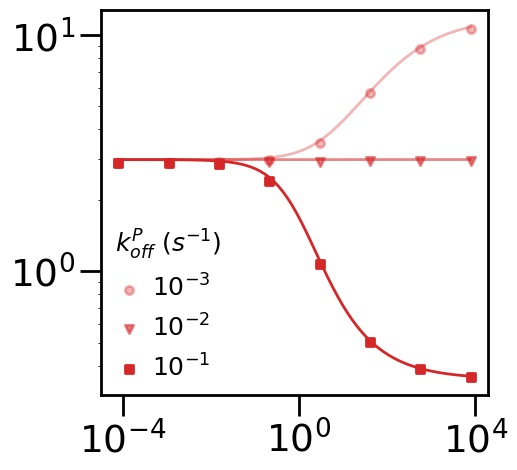

In [17]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.01], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbList = np.unique(parm_ana['kbPP'])
for i, kbP in enumerate(kbList):
    selected = parm_ana['kbPP']==kbP
    ax.plot(
        (parm_ana['KPP']*parm_ana['CP0'])[selected],
        (resTs*parm_ana['kbPS'])[selected],
        lw=2, color='tab:red', alpha=alphas[i],
    )
    selected_num = parm_num['kbPP']==kbP
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (resT_num_rev*parm_num['kbPS'])[selected_num],
        lw=2, zorder=5, marker=markers[i], 
        label='$10^{%.0f}$'%np.log10(kbP),
        color='tab:red', alpha=alphas[i], 
    )
ax.loglog()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks([1e-4,1e0,1e4],['$10^{-4}$', '$10^{0}$', '$10^{4}$'],**tickfont)
plt.yticks(**tickfont)
# plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)
plt.show()

In [11]:
parm = parm_num
equi = equi_num_rev

# get parameters
NPsys = (equi[['P', 'PN', 'PS', 'PSN']].sum(axis=1) \
      + 2*equi[['PP', 'PPN', 'PPS', 'PSPN', 'PPSN', 'PNPN', 'PNPSN']].sum(axis=1)).to_numpy()
v = NPsys / parm['CP0'].to_numpy()
kaPS = parm['kaPS'].to_numpy()
kaPN = parm['kaPN'].to_numpy()
kaPP = parm['kaPP'].to_numpy()
# get equilibrium 
Peq = equi['P'].to_numpy()
PPeq = equi['PP'].to_numpy()
pBound_mon = equi[['PN', 'PS', 'PSN']].sum(axis=1).to_numpy()
pBound_dim = 2*equi[['PPN', 'PPS', 'PSPN', 'PPSN', 'PNPN', 'PNPSN']].sum(axis=1).to_numpy()
# calculate the DNA on rate
r_on_P = ((kaPS*equi['S'] + kaPN*equi['N'])/v * Peq).to_numpy()
r_on_PP = ((kaPS*equi['S'] + kaPN*equi['N'])/v * (2*2*PPeq)).to_numpy()
r_on_P_P = ((equi['PN'] + equi['PS'] + equi['PSN'])/v * 2*kaPP * Peq).to_numpy()
# analytical estimates:
kbPS = parm['kbPS'].to_numpy()
kbPN = parm['kbPN'].to_numpy()
kbPP = parm['kbPP'].to_numpy()
chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
# chiN = parm['KPN'].to_numpy()*equi['N'].to_numpy()/v
chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
# chiS = parm['KPS'].to_numpy()*equi['S'].to_numpy()/v
gamma = parm['gamma'].to_numpy()
tau_mon = (chiN + chiS + gamma*chiS*chiN) / (kbPS*chiS + kbPN*chiN)
tau_dim = 2*(2*chiN + 2*chiS + 4*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS) / \
        (4*(kbPS*chiS + kbPN*chiN) + 2*kbPP*(chiN + chiS + gamma*chiS*chiN))

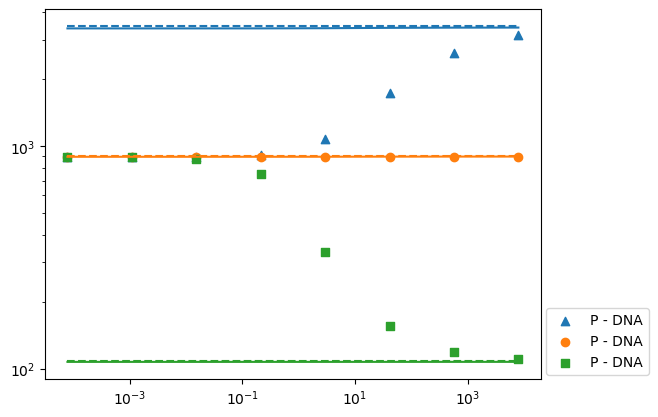

[0.001 0.01  0.1  ] ['^', 'o', 's']


In [12]:
markers = ['^', 'o', 's']
kbList = np.unique(parm_ana['kbPP'])
for i, kbP in enumerate(kbList):
    selected_num = parm_num['kbPP']==kbP
    plt.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        ((pBound_mon+pBound_dim)/(r_on_P+r_on_PP+r_on_P_P))[selected_num], 
        label='P - DNA', marker=markers[i],
        color=colors[i],
    )
    plt.plot(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        ((pBound_dim)/(r_on_PP+r_on_P_P))[selected_num], 
        color=colors[i],
    )
    plt.plot(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (tau_dim)[selected_num], 
        color=colors[i], ls='--'
    )
plt.loglog()
plt.legend(loc=[1.01,0.01])
plt.show()
print(kbList, markers)

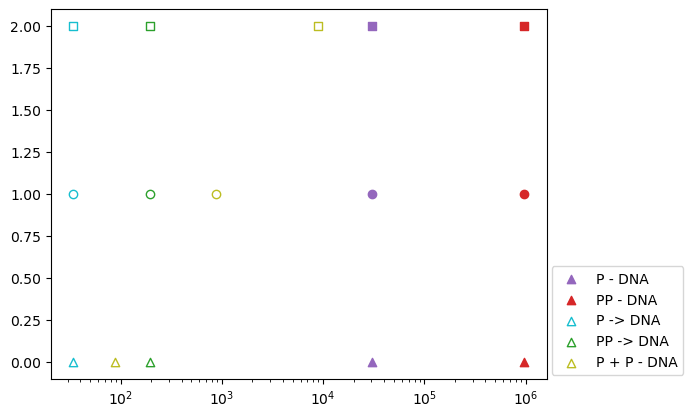

[0.001 0.01  0.1  ] ['^', 'o', 's']


In [13]:
markers = ['^', 'o', 's']
kbList = np.unique(parm_ana['kbPP'])
colors = ['tab:purple', 'tab:red', 'tab:cyan', 'tab:green', 'tab:olive']
for i, kbP in enumerate(kbList):
    selected_num = parm_num['kbPP']==kbP
    if i == 0:
        labels = ['P - DNA', 'PP - DNA', 'P -> DNA', 'PP -> DNA', 'P + P - DNA']
    else:
        labels = ['', '', '', '', '']
    plt.scatter(
        pBound_mon[selected_num][-1], i, label=labels[0], marker=markers[i],
        color=colors[0],
    )
    plt.scatter(
        pBound_dim[selected_num][-1], i, label=labels[1], marker=markers[i],
        color=colors[1],
    )
    plt.scatter(
        r_on_P[selected_num][-1], i, label=labels[2], marker=markers[i], 
        edgecolor=colors[2], facecolor='white',
    )
    plt.scatter(
        r_on_PP[selected_num][-1], i, label=labels[3], marker=markers[i], 
        edgecolor=colors[3], facecolor='white',
    )
    plt.scatter(
        r_on_P_P[selected_num][-1], i, label=labels[4], marker=markers[i], 
        edgecolor=colors[4], facecolor='white',
    )
plt.legend(loc=[1.01,0.01])
plt.semilogx()
plt.show()
print(kbList, markers)

# critical rate 

In [4]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

In [16]:
GenParms = lambda gamma, nData: GenParameters(
    numTargets=2, KPS=lambda KPN: 1000*KPN, kaPS=1000, kaPN=200,
    KPN=2*np.logspace(1,3,nData), NP0=[0.1], gamma=[gamma],
    KPP=np.logspace(1,9,nData), kbPP_fixed=kbP   
)
parm_G1 = GenParms(1, 50)
parm_G10 = GenParms(10, 50)
parm_G100 = GenParms(100, 50)

In [59]:
parm_G1['CN0']

0       0.000476
1       0.000476
2       0.000476
3       0.000476
4       0.000476
          ...   
2495    0.000476
2496    0.000476
2497    0.000476
2498    0.000476
2499    0.000476
Name: CN0, Length: 2500, dtype: float64

In [24]:
(parm_G1['KPN']*parm_G1['CN0'])

0       0.015815
1       0.015815
2       0.015815
3       0.015815
4       0.015815
          ...   
2495    1.581503
2496    1.581503
2497    1.581503
2498    1.581503
2499    1.581503
Length: 2500, dtype: float64

In [15]:
cRates = criticalRate(parm)

In [26]:
cRate = {
    'chiPN':np.round(np.log10(parm_G1['KPN']*parm_G1['CN0'], 2), 
    'lnKPP':np.round(np.log(CP62nM_parm['KPP']/C0), 2),
    'resT_Nonly':CP62nM.resT_Nonly,
    'resT_singleS':CP62nM.resT_singleS,
    'resT_doubleS':CP62nM.resT_doubleS
}
dfCP62nM = pd.DataFrame(dfCP62nM)

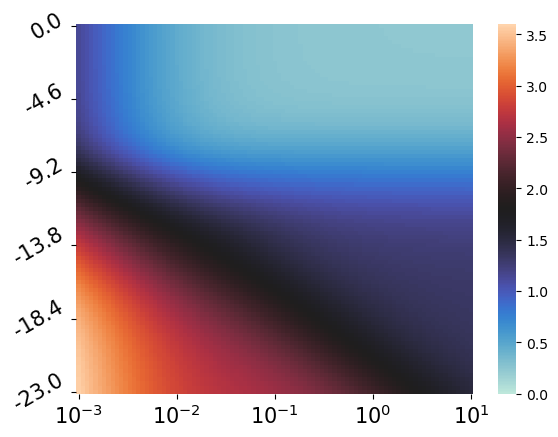

In [27]:
ax = sns.heatmap(
    np.log10(
        dfCP62nM.pivot(
            index="lnKPP", columns="tauPN", values="resT_doubleS"
        )/dfCP62nM.pivot(
            index="lnKPP", columns="tauPN", values="resT_Nonly"
        )
    ),
    vmin=0, vmax=3.6, 
    cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=23, yticklabels=18
)

xticklabels_plot = ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']
ax.set_xticks(ax.get_xticks(), xticklabels_plot, fontsize=15, rotation=0)

ax.set_yticks(
    ax.get_yticks(), 
    ['0.0', '-4.6', '-9.2', '-13.8', '-18.4', '-23.0'], 
    fontsize=15, rotation=30
)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

# c) residence time v.s. chiPN & gamma, dimer, model B

In [304]:
GenParm = lambda numTarg, nDenseKPN, KPP: GenParameters(
    numTargets=numTarg, KPN=np.logspace(1, 3, 5+2*nDenseKPN)*2.0, 
    KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=[KPP], area3Dto1D=[1, 100], kbPP_fixed=1e-3,
)
# For analytics, KPP does not affect "irr" mor "m", so set it to the value for reversible
KPP = 1e9
parm_ana_B = GenParm(2, 40, KPP)
parm_ana_A = GenParm(0, 40, KPP)
# For numerics, KPP maters
parm_num_B = GenParm(2, 0, KPP)
parm_num_B_m = GenParm(2, 0, 0)
parm_num_B_irr = GenParm(2, 0, np.inf)
parm_num_A = GenParm(0, 0, KPP)
parm_num_A_m = GenParm(0, 0, 0)
parm_num_A_irr = GenParm(0, 0, np.inf)

In [305]:
np.unique(parm_ana_B['CP0'])/0.6022, np.unique(parm_ana_B['KPP']*parm_ana_B['CP0'])

(array([7.90751372e-06]), array([7907.51371954]))

In [306]:
np.unique(parm_ana_B['gamma'])

array([  10., 1000.])

In [252]:
# calculate the residence time considering PSN
def calc_tauB_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    kaStokaN = parms['kaPS']/parms['kaPN']
    CS0toCN0 = parms['CS0']/parms['CN0']
    tauN = 1/parms['kbPN']
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+kaStokaN*CS0toCN0)*tauN

# calculate the residence time considering PSNPN
def calc_tauB_irr(parm_file):
    gam = parm_file['gamma']
    chiN = parm_file['KPN']*parm_file['CN0']
    chiS = parm_file['KPS']*parm_file['CS0']
    kaStokaN = parm_file['kaPS']/parm_file['kaPN']
    CS0toCN0 = parm_file['CS0']/parm_file['CN0']
    tauN = 1/parm_file['kbPN']
    return (2*chiN+gam*chiN**2+2*chiS*(1+gam*chiN)**2)/2/chiN/(1+kaStokaN*CS0toCN0) * tauN

# calculate the residence time considering PNPN
def calc_tauA_irr(parm_file):
    gam = parm_file['gamma']
    chiN = parm_file['KPN']*parm_file['CN0']
    return (1 + gam*chiN/2) / parm_file['kbPN']

parmSize = parm_ana_B.shape[0]
# ratio when KPP -> infty
resT_irr_B2A = calc_tauB_irr(parm_ana_B)/ calc_tauA_irr(parm_ana_A)
# ratio when KPP=0, tauA_m = 1/kbPN
resT_m_B2A = calc_tauB_m(parm_ana_B) * parm_ana_A['kbPN']
# ratio when KPP is finite
resT_rev_B2A = np.zeros(parmSize)
for iloc in range(parmSize):
    resT_rev_B2A[iloc] = ana.ana_resTime_balance(parm_ana_B.iloc[iloc], numClusterS=1)\
    / ana.ana_resTime_balance(parm_ana_A.iloc[iloc], numClusterS=0)

In [253]:
equi_B_irr = numericSolver(parm_df=parm_num_B_irr, labels=labelsSingleS, model=rxnSingleS)
equi_B_rev = numericSolver(parm_df=parm_num_B, labels=labelsSingleS, model=rxnSingleS)
equi_B_m = numericSolver(parm_df=parm_num_B_m, labels=labelsSingleS, model=rxnSingleS)
equi_A_irr = numericSolver(parm_df=parm_num_A_irr, labels=labelsNonly, model=rxnNonly)
equi_A_rev = numericSolver(parm_df=parm_num_A, labels=labelsNonly, model=rxnNonly)
equi_A_m = numericSolver(parm_df=parm_num_A_m, labels=labelsNonly, model=rxnNonly)

2024-10-31 15:07:40.507235
Number of cores used:  10/36
Finished parallel processing.
2024-10-31 15:07:40.953023
Number of cores used:  10/36
Finished parallel processing.
2024-10-31 15:07:41.528034
Number of cores used:  10/36
Finished parallel processing.
2024-10-31 15:07:41.919779
Number of cores used:  10/36
Finished parallel processing.
2024-10-31 15:07:42.094547
Number of cores used:  10/36
Finished parallel processing.
2024-10-31 15:07:42.327969
Number of cores used:  10/36
Finished parallel processing.


In [254]:
numSize = parm_num_B.shape[0]
resT_num_irr_B2A = np.zeros(numSize)
resT_num_rev_B2A = np.zeros(numSize)
resT_num_m_B2A = np.zeros(numSize)
for iloc in range(numSize):
    resT_num_irr_B2A[iloc] = num.calc_resT_modelB(parm_num_B_irr.iloc[iloc], equi_B_irr.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A_irr.iloc[iloc], equi_A_irr.iloc[iloc])
    resT_num_rev_B2A[iloc] = num.calc_resT_modelB(parm_num_B.iloc[iloc], equi_B_rev.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A.iloc[iloc], equi_A_rev.iloc[iloc])
    resT_num_m_B2A[iloc] = num.calc_resT_modelB(parm_num_B_m.iloc[iloc], equi_B_m.iloc[iloc])\
    / num.calc_resT_modelA(parm_num_A_m.iloc[iloc], equi_A_m.iloc[iloc])

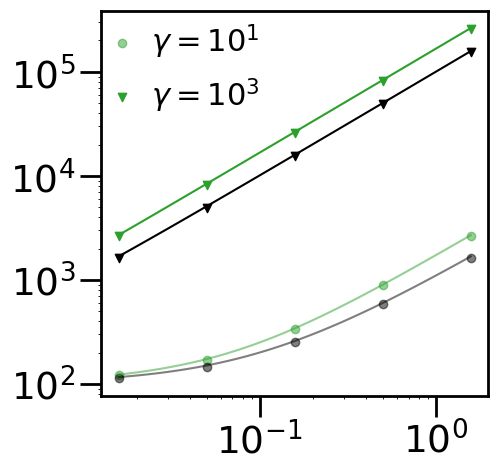

In [256]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.7], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
gamList = np.unique(parm_ana_B['gamma'])
for i, gam in enumerate(gamList):
    # analytics
    selected = parm_ana_B['gamma']==gam
#     ax.plot(
#         (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
#         (resT_rev_B2A)[selected], ls='--',
#         color=color_gamma, alpha=alphas[i], 
#     )
    ax.plot(
        (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
        (resT_irr_B2A)[selected],
        color=color_gamma, ls='-', alpha=alphas[i], 
    )
    # analytics, monomer limit
    ax.plot(
        (parm_ana_B['KPN']*parm_ana_B['CN0'])[selected],
        (resT_m_B2A)[selected],
        color='black', ls='-', alpha=alphas[i], 
    )
    # numerics
    selected_num = (parm_num_B['gamma']==gam)
    ax.scatter(
        (parm_num_B['KPN']*parm_num_B['CN0'])[selected_num],
        (resT_num_irr_B2A)[selected_num],
        color=color_gamma, alpha=alphas[i], marker=markers[i],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
#     ax.scatter(
#         (parm_num_B['KPN']*parm_num_B['CN0'])[selected_num],
#         (resT_num_rev_B2A)[selected_num],
#         label='$\\gamma=10^{%.0f}$'%np.log10(gam),
#         color=color_gamma, alpha=alphas[i], marker=markers[i],
#     )
    # numerics, monomer limit
    ax.scatter(
        (parm_num_B['KPN']*parm_num_B['CN0'])[selected_num],
        (resT_num_m_B2A)[selected_num],
        color='black', alpha=alphas[i], marker=markers[i],
    )
# ax.semilogx()
ax.loglog()
# ax.set_ylim([1e1,5e5])
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

In [100]:
np.log10(np.unique(parm_ana_B['KPP']*parm_ana_B['CP0']))

array([3.89803995])

# d) protein bound ratio (irr, rev, m)

In [238]:
GenParms = lambda KPNList, KPP: GenParameters(
    numTargets=2, KPN=KPNList, KPS=lambda KPN: 2e4, 
    NP0=[0.03], KPP=[KPP], area3Dto1D=[10, 1000],
)
KPP_rev = 1e6

In [239]:
parm_ana = GenParms(np.logspace(1, 3, 5+2*40)*2.0, KPP_rev)

parm_num_irr = GenParms(np.logspace(1, 3, 5+2*0)*2.0, np.inf)
parm_num_rev = GenParms(np.logspace(1, 3, 5+2*0)*2.0, KPP_rev)
parm_num_m = GenParms(np.logspace(1, 3, 5+2*0)*2.0, 0)

In [241]:
np.unique(parm_ana['CP0'])/0.6022

array([2.37225412e-06])

In [59]:
def pBound_irr(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    return proBound / (1 + proBound)

def pBound_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = chiN + chiS*(1+gam*chiN)
    return proBound / (1 + proBound)

pBound_irr = pBound_irr(parm_ana)
pBound_m = pBound_m(parm_ana)
pBound_rev = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    pBound_rev[iloc] = ana.ana_bound_ratio(parm_ana.iloc[iloc], numClusterS=1)

In [60]:
equi_irr = numericSolver(parm_df=parm_num_irr, labels=labelsSingleS, model=rxnSingleS)
equi_m = numericSolver(parm_df=parm_num_m, labels=labelsSingleS, model=rxnSingleS)
equi_rev = numericSolver(parm_df=parm_num_rev, labels=labelsSingleS, model=rxnSingleS)

pBound_num_m = np.zeros(parm_num_m.shape[0])
pBound_num_irr = np.zeros(parm_num_m.shape[0])
pBound_num_rev = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelB(parm_num_m.iloc[iloc], equi_m.iloc[iloc])
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelB(parm_num_irr.iloc[iloc], equi_irr.iloc[iloc])
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm_num_rev.iloc[iloc], equi_rev.iloc[iloc])

2024-10-30 13:54:23.681228
Number of cores used:  10/36
Finished parallel processing.
2024-10-30 13:54:24.181745
Number of cores used:  10/36
Finished parallel processing.
2024-10-30 13:54:24.620458
Number of cores used:  10/36
Finished parallel processing.


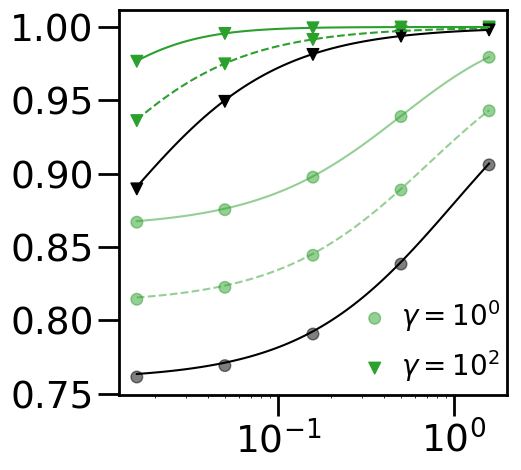

In [65]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_ana['gamma']==gam))
    # analytics
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_irr[selected], ls='-',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_rev[selected], ls='--',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_rev[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
    )
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num],
        pBound_num_m[selected_num],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks([0.75, 0.8, 0.85, 0.9, 0.95, 1], **tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()

In [62]:
np.unique(parm_ana['KPP']*parm_ana['CP0'])

array([2.37225412])

# d) and e) Target occupancy v.s.  KPP & gamma?

In [307]:
GenParms = lambda nDenseKPP: GenParameters(
    numTargets=2, KPN=np.array([52]), KPS=lambda KPN: 1e3, 
    NP0=[2], KPP=np.logspace(1,10,10+9*nDenseKPP), 
    area3Dto1D=[1, 4, 20],
)
parm_file = GenParms(10)
parm_num = GenParms(0)

In [308]:
np.unique(parm_file['CP0'])/0.6022*1e3, np.unique(parm_file['CS0'])/0.6022*1e3

(array([0.15815027]), array([0.15815027]))

In [313]:
np.unique(parm_file['gamma']*parm_file['KPN']*parm_file['CN0'])

array([ 2.05595357, 10.27976784, 41.11907134])

In [310]:
pBound = np.zeros(parm_file.shape[0])
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

In [311]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

pBound_num_rev = np.zeros(parm_num.shape[0])
sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm, equi_num_rev.iloc[iloc])
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2024-11-01 16:58:52.057607
Number of cores used:  30/36
Finished parallel processing.


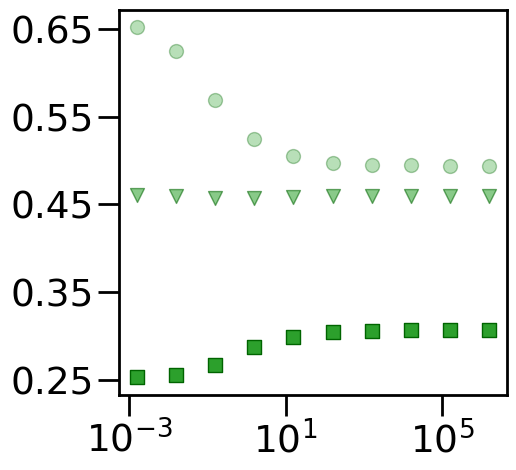

In [312]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.45], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$\gamma$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
gam_color = 'tab:green'
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList[::-1]):
    selected = ((parm_file['gamma']==gam))
    selected_num = ((parm_num['gamma']==gam))
#     ax.plot(
#         (parm_file['KPP']*parm_file['CP0'])[selected],
#         (occs / (parm_file['CP0']/parm_file['CS0']))[selected], 
#         color = gam_color, alpha=alphas[i], 
#         lw=2, zorder=5,
#     )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
        marker=markers[i],  zorder=4, s=100,
        color = gam_color, edgecolor='darkgreen', alpha=alphas[i], 
        label='$10^{%.0f}$'%(np.log10(gam)),
    )
            
ax.semilogx()
# plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks([0.25, 0.35, 0.45, 0.55, 0.65],**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

In [233]:
GenParms = lambda nDenseKPP: GenParameters(
    numTargets=2, KPN=np.array([50]), KPS=lambda KPN: 5e4, 
    NP0=[2], KPP=np.logspace(1,10,10+9*nDenseKPP), 
    area3Dto1D=[1, 4, 20],
)
parm_file = GenParms(10)
parm_num = GenParms(0)

In [234]:
pBound = np.zeros(parm_file.shape[0])
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

In [235]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

pBound_num_rev = np.zeros(parm_num.shape[0])
sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm, equi_num_rev.iloc[iloc])
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2024-10-31 14:39:52.845134
Number of cores used:  30/36
Finished parallel processing.


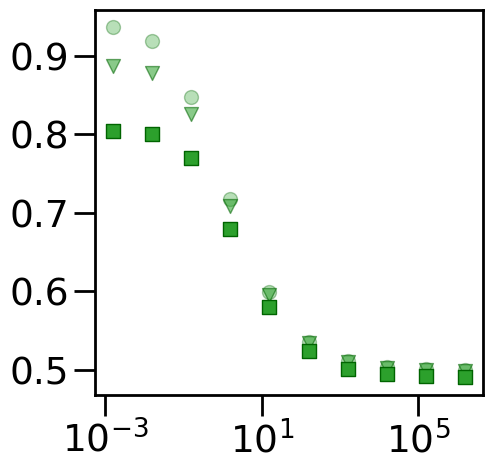

In [237]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.45], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$\gamma$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
gam_color = 'tab:green'
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList[::-1]):
    selected = ((parm_file['gamma']==gam))
    selected_num = ((parm_num['gamma']==gam))
#     ax.plot(
#         (parm_file['KPP']*parm_file['CP0'])[selected],
#         (occs / (parm_file['CP0']/parm_file['CS0']))[selected], 
#         color = gam_color, alpha=alphas[i], 
#         lw=2, zorder=5,
#     )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
        marker=markers[i],  zorder=4, s=100,
        color = gam_color, edgecolor='darkgreen', alpha=alphas[i], 
        label='$10^{%.0f}$'%(np.log10(gam)),
    )
            
ax.semilogx()
# plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

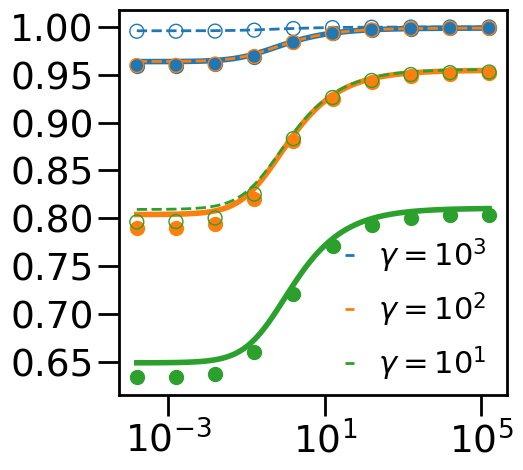

In [17]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                pBound[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

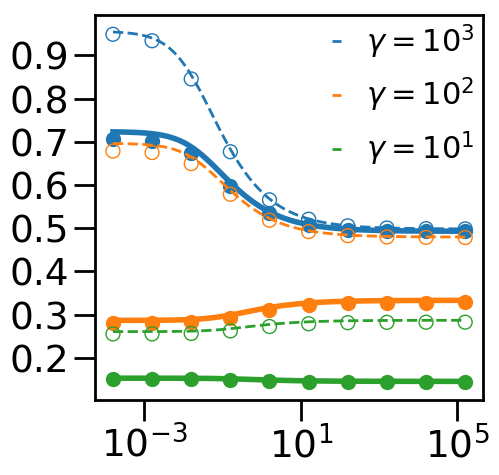

In [84]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.58,0.57], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (occs / (parm_file['CP0']/parm_file['CS0']))[selected],
                ls = lineStyles[j], color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (occs / (parm_file['CP0']/parm_file['CS0']))[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=5,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

#### extremely weak target binding

In [86]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False, hasTargets = True):
    
    kaPN = lambda K: np.round(200,10)
    kbPN = lambda K: np.round(kaPN(K)/K,10)
    
    kaPS = lambda K: np.round(1000,10)
    kbPS = lambda K: np.round(kaPS(K)/K,10)
    
    kbPP = lambda K: np.round(10 / (K*C0/1e1)**(4/9), 10)
    kaPP = lambda K: np.round(K*kbPP(K), 10)
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    if hasTargets:
        CN0 = 10/V0 # nm^-3
        CS0 = 2/V0
    else:
        CN0 = 12/V0 # nm^-3
        CS0 = 20/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, hasTargets = True,
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, \
    CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0, hasTargets)

    # These parameters are fixed
    CP0 = 0.2/V0
    KPS = 1e2 * 2/C0
    # These parameters are varied
    for KPN in np.array([20, 200])/C0:
        for area3Dto1D in [1,10]:
            for KPP in np.logspace(1,10,10+9*nDenseKPP)/C0:
                entry = {
                    'ID':number,
                    "CN0":CN0,
                    "CS0":CS0,
                    "CP0":CP0,
                    "KPN":np.round(KPN, 10),
                    "kaPN":kaPN(KPN),
                    "kbPN":kbPN(KPN),
                    "KPS":np.round(KPS, 10),
                    "kaPS":kaPS(KPS),
                    "kbPS":kbPS(KPS),
                    "KPP":np.round(KPP, 10),
                    "kaPP":kaPP(KPP),
                    "kbPP":kbPP(KPP),
                    "gamma":VtoL/area3Dto1D
                }
                data.append(entry)
                number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(plotDenseData=True, hasTargets=True)
parm_num = GenerateParameters_or_write(plotDenseData=False, hasTargets=True)

In [87]:
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

In [88]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=task_rev)

sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2024-08-15 15:59:21.873313
Number of cores used:  34/36
Finished parallel processing.


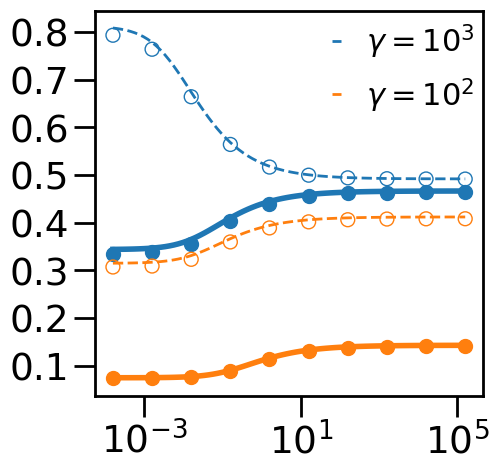

In [89]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.58,0.7], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader()
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# colors = colors[1:]
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (occs / (parm_file['CP0']/parm_file['CS0']))[selected],
                ls = lineStyles[j], color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (occs / (parm_file['CP0']/parm_file['CS0']))[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=5,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

#### test assumption

In [58]:
def est_CPeq(parm_file):
    
    result = np.zeros(parm_file.shape[0])
    
    for i in range(parm_file.shape[0]):
        
        parm = parm_file.iloc[i]
        
        chiS = parm['KPS']*parm['CS0']
        chiN = parm['KPN']*parm['CN0']
        gamma = parm['gamma']
        chiP = parm['CP0']*parm['KPP']

        a = 2*(1+2*chiS*(1+gamma*chiN)**2)*chiP
        b = 1 + chiS + chiS*gamma*chiN
        c = 1

        delta = b**2 - 4*a*c

        if delta > 0:
            result[i] = (-b + np.sqrt(b**2 - 4*a*c))/2/a * parm['CP0']
        else:
            pass
    return result

CPeq_est = est_CPeq(parm_file)

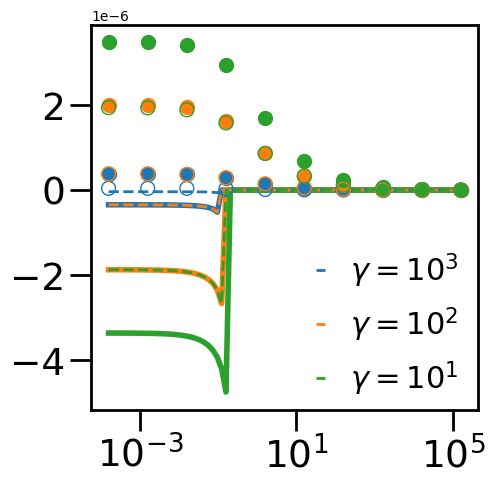

In [61]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader()
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (CPeq_est)[selected],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (equi_num_rev['P']/1e6*parm_num['CP0'])[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_file['KPP']*parm_file['CP0'])[selected],
                (CPeq_est)[selected],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (equi_num_rev['P']/1e6*parm_num['CP0'])[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

[]

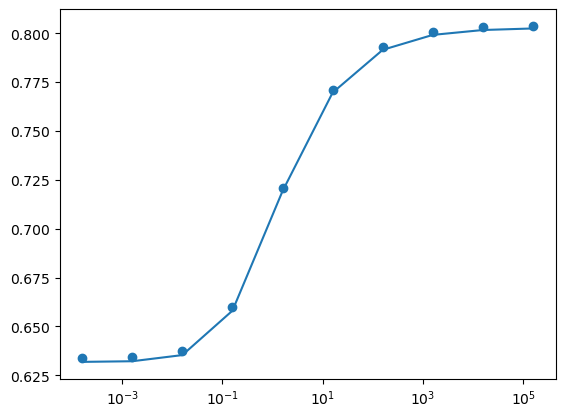

In [52]:
kpnList = np.unique(parm_num['KPN'])
gamList = np.unique(parm_num['gamma'])
kpn = kpnList[0]
gam = gamList[0]
selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))

pBoundEst = (
    equi_num_rev['PSN'] + equi_num_rev['PS']  \
    +2*(equi_num_rev['PPS']+equi_num_rev['PPSN']+equi_num_rev['PSPN']+equi_num_rev['PNPSN'])
)
pFreeReal = equi_num_rev['P'] + 2*equi_num_rev['PP']

plt.plot(
    (parm_num['KPP']*parm_num['CP0'])[selected_num],
    (pBoundEst / (pBoundEst + pFreeReal))[selected_num]
)
plt.scatter(
    (parm_num['KPP']*parm_num['CP0'])[selected_num],
    pBound_num_rev[selected_num],
)

plt.semilogx()

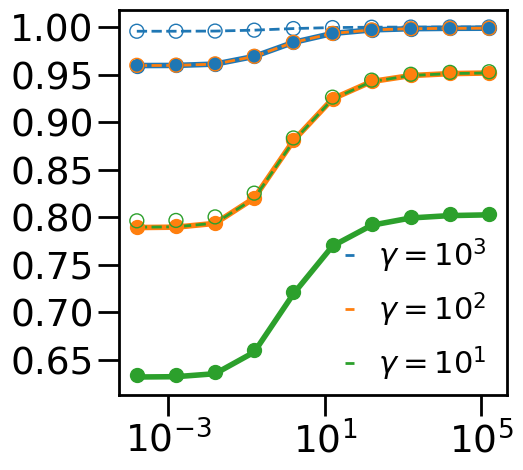

In [55]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader()
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
kpnList = np.unique(parm_file['KPN'])
for i, gam in enumerate(gamList[::-1]):
    for j, kpn in enumerate(kpnList):
        selected = ((parm_file['gamma']==gam)&(parm_file['KPN']==kpn))
        selected_num = ((parm_num['gamma']==gam)&(parm_num['KPN']==kpn))
        if j==0:
            ax.plot(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (pBoundEst / (pBoundEst + pFreeReal))[selected_num],
                ls = lineStyles[j], zorder=1,
                color = colors[i], lw=4,
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=3, s=100,
            )
        elif j==1:
            ax.plot(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                (pBoundEst / (pBoundEst + pFreeReal))[selected_num],
                ls = lineStyles[j], color = colors[i], 
                lw=2, zorder=2,
                label='$\\gamma=10^{%.0f}$'%(np.log10(gam)),
            )
            ax.scatter(
                (parm_num['KPP']*parm_num['CP0'])[selected_num],
                pBound_num_rev[selected_num],
                color = colors[i], zorder=4, s=100,
                marker='o', facecolor='none',
            )
            
            
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

# Archived (including some heatmaps)

## void) protein bound ratio (from monomer to dimer) v.s.  KPN & gamma

In [4]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False):
    
    kaPN = lambda K: 200
    kbPN = lambda K: kaPN(K)/K
    
    kaPS = lambda K: 1000
    kbPS = lambda K: kaPS(K)/K
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    CN0 = 12/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0)
    # These parameters are fixed
    CP0 = 0.1/V0
    KPP = np.exp(23)/C0
    kbPP = lambda K: 10 / (KPP*C0/1e1)**(4/9)
    kaPP = lambda K: K*kbPP(K)
    KPS = 1e3 * 1e1*2/C0
    # These parameters are varied
    for KPN in np.logspace(1, 3, 3+2*nDenseKPN)*2.0/C0:
        for area3Dto1D in [16, 100]:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":np.round(kaPN(KPN), 10),
                "kbPN":np.round(kbPN(KPN), 10),
                "KPS":np.round(KPS, 10),
                "kaPS":np.round(kaPS(KPS), 10),
                "kbPS":np.round(kbPS(KPS), 10),
                "KPP":np.round(KPP, 10),
                "kaPP":np.round(kaPP(KPP), 10),
                "kbPP":np.round(kbPP(KPP), 10),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
    denseKPN=True, denseKPP=True, denseCP0=True,
)

In [5]:
# get equilibrium
equi_file = numericSolver(parm_df=parm_file, labels=labels, model=process_task)
# calculate observables
pBounds = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    __parmi = parm_file.iloc[iloc]
    __equii = equi_file.iloc[iloc]
    if __parmi['ID'] != __equii['ID']:
        raise ValueError('ID not matched')
    else:
        pBounds[iloc]=num.calc_BoundRatio_modelB(parm=__parmi, equi=__equii)

2024-08-06 14:05:57.152419
Number of cores used:  34/36
Finished parallel processing.


In [11]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False):
    
    kaPN = lambda K: 200
    kbPN = lambda K: kaPN(K)/K
    
    kaPS = lambda K: 1000
    kbPS = lambda K: kaPS(K)/K
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    CN0 = 12/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0)
    # These parameters are fixed
    CP0 = 0.1/V0
    KPP = np.exp(0)/C0
    kbPP = lambda K: 10 / (KPP*C0/1e1)**(4/9)
    kaPP = lambda K: K*kbPP(K)
    KPS = 1e3 * 1e1*2/C0
    # These parameters are varied
    for KPN in np.logspace(1, 3, 3+2*nDenseKPN)*2.0/C0:
        for area3Dto1D in [16, 100]:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":np.round(kaPN(KPN), 10),
                "kbPN":np.round(kbPN(KPN), 10),
                "KPS":np.round(KPS, 10),
                "kaPS":np.round(kaPS(KPS), 10),
                "kbPS":np.round(kbPS(KPS), 10),
                "KPP":np.round(KPP, 10),
                "kaPP":np.round(kaPP(KPP), 10),
                "kbPP":np.round(kbPP(KPP), 10),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file_monomer = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
    denseKPN=True, denseKPP=True, denseCP0=True,
)

In [12]:
# get equilibrium
equi_file_monomer = numericSolver(parm_df=parm_file_monomer, labels=labels, model=process_task)
# calculate observables
pBounds_monomer = np.zeros(parm_file_monomer.shape[0])
for iloc in range(parm_file_monomer.shape[0]):
    __parmi = parm_file_monomer.iloc[iloc]
    __equii = equi_file_monomer.iloc[iloc]
    if __parmi['ID'] != __equii['ID']:
        raise ValueError('ID not matched')
    else:
        pBounds_monomer[iloc]=num.calc_BoundRatio_modelB(parm=__parmi, equi=__equii)

2024-08-06 14:08:17.076442
Number of cores used:  34/36
Finished parallel processing.


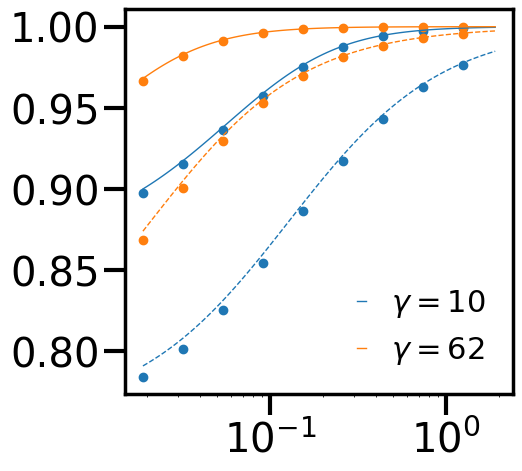

In [13]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':29*scale}
legend = {'fontsize':22*scale, 'loc':'lower right', 'handlelength':0.3*scale, 
#           'title':'$\\gamma$', 
          'title_fontsize':22*scale,
         'framealpha':0.0}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
# ax = plt.gca()
plt.tick_params(length=15*scale, width=3*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.5*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
colors = ['tab:blue', 'tab:orange', 'tab:green']
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    chiPN = parm_file['KPN'][selected]*parm_file['CN0'][selected]
    chiPS = parm_file['KPS'][selected]*parm_file['CS0'][selected]
    bounddimers = 2*chiPN + gam*chiPN**2 + 2*chiPS*(1+gam*chiPN)**2
    ax.plot(
        chiPN,
        bounddimers/(1+bounddimers),
        ls = '-', color = colors[i], lw=1,
        label='$\\gamma=%2.0f$'%gam
    )
    ax.scatter(
        chiPN[::10], 
        pBounds[selected][::10],
        color = colors[i],
    )
    ## monomer binding ratio
    chiPS = parm_file['KPS'][selected]*parm_file['CS0'][selected]
    ax.plot(
        chiPN, 
        (chiPN+chiPS*(1+gam*chiPN))/(1+chiPN+chiPS*(1+gam*chiPN)),
        ls='--', color = colors[i], lw=1,
    )
    ax.scatter(
        chiPN[::10], 
        pBounds_monomer[selected][::10],
        color = colors[i],
    )

ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

## void) Target occupancy v.s.  KPP & KPN?

In [60]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False):
    
    kaPN = lambda K: 200
    kbPN = lambda K: kaPN(K)/K
    
    kaPS = lambda K: 1000
    kbPS = lambda K: kaPS(K)/K
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    CN0 = 12/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0)
    # These parameters are fixed
    CP0 = 0.2/V0
    area3Dto1D = 100
    KPS = 1e3 * 1e1*2.0/C0
    # These parameters are varied
    for KPP in np.logspace(1,10,10+9*nDenseKPP)/C0:
        kbPP = lambda K: 10 / (KPP*C0/1e1)**(4/9)
        kaPP = lambda K: K*kbPP(K)
        for KPN in np.logspace(1, 3, 3+2*nDenseKPN)*2.0/C0:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":np.round(kaPN(KPN), 10),
                "kbPN":np.round(kbPN(KPN), 10),
                "KPS":np.round(KPS, 10),
                "kaPS":np.round(kaPS(KPS), 10),
                "kbPS":np.round(kbPS(KPS), 10),
                "KPP":np.round(KPP, 10),
                "kaPP":np.round(kaPP(KPP), 10),
                "kbPP":np.round(kbPP(KPP), 10),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
    denseKPN=False, denseKPP=True, denseCP0=True,
)

In [61]:
pBound = np.zeros(parm_file.shape[0])
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=1)
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

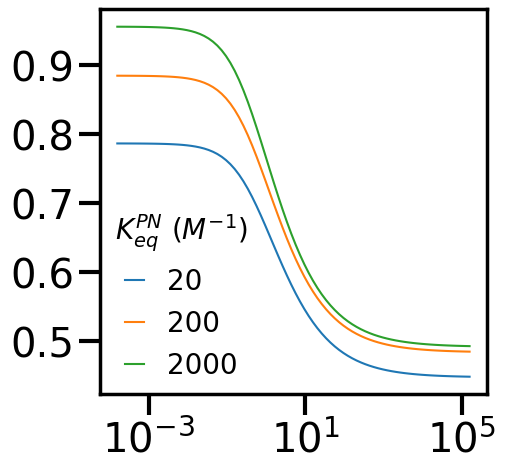

In [62]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':29*scale}
legend = {'fontsize':20*scale, 'loc':[0.01,0.01], 'handlelength':0.7*scale, 
          'title':'$K_{eq}^{PN}$ ($M^{-1}$)', 
          'title_fontsize':20*scale,
         'framealpha':0.0}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
plt.tick_params(length=15*scale, width=3*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.5*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
colors = ['tab:blue', 'tab:orange', 'tab:green']
kpnList = np.unique(parm_file['KPN'])
for i, KPN in enumerate(kpnList):
    selected = ((parm_file['KPN']==KPN))
    chiPN = parm_file['KPN'][selected]*parm_file['CN0'][selected]
    ax.plot(
        parm_file['KPP'][selected]*parm_file['CP0'][selected],
        occs[selected] / (parm_file['CP0'][selected]/parm_file['CS0'][selected]),
        ls = '-', color = colors[i],
        label='%.0f'%(KPN*C0)
    )
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], ['$10^{-3}$', '$10^{1}$', '$10^{5}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

## Plot residence time for strong and weak dimerizations

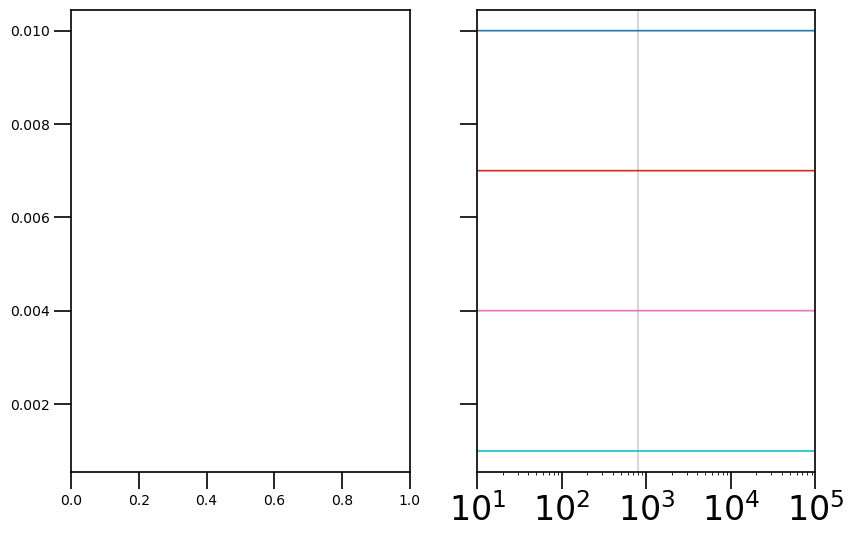

In [8]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale*1.0, 'loc':'best', 'handlelength':1.4*scale*1.0, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale*1.0}

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16*scale,10*scale))
for ax in axes:
    ax.tick_params(length=20*scale,width=2*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2*scale)  # change width

C0 = 0.6022

# ## plot for fixed protein concentration

# parm_file = CP62nM_parm

# KPN_list = np.unique(parm_file['KPN'])
# colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

# KPN_list = KPN_list[::46]
# colors = colors[::46]
# axes[0].axvline(np.log(1e8/C0), color='gray', alpha=0.3)
# for i, KPNi in enumerate(KPN_list):
#     # select data
#     KPN_select = (parm_file['KPN']==KPNi)
#     # plot analytical results for model A
#     axes[0].plot(
#         np.log(parm_file['KPP'][KPN_select]/C0), 
#         np.array(CP62nM_ana.resT_Nonly)[KPN_select], 
#         color=colors[i], ls='-', lw=2*scale,
#         label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
#     )
#     ## for model B
#     axes[0].plot(
#         np.log(parm_file['KPP'][KPN_select]/C0), 
#         np.array(CP62nM_ana.resT_singleS)[KPN_select], 
#         color=colors[i], ls='--', lw=2*scale,
#     )
#     ## for model C
#     axes[0].plot(
#         np.log(parm_file['KPP'][KPN_select]/C0), 
#         np.array(CP62nM_ana.resT_doubleS)[KPN_select], 
#         color=colors[i], ls='-.', lw=2*scale,
#     )

# axes[0].semilogy()
# axes[0].set_xlim([0, 23])
# axes[0].set_xticks(
#     [0,  5, 11, 17, 23], [0, -5, -11, -17, -23], **tickfont
# )
# axes[0].set_ylim([0.8e-6,1e1])
# # axes[0].set_yticks(
# #     [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6], 
# #     ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$', '$10^{6}$'], 
# #     **tickfont
# # )
# axes[0].legend(**legend)

## plot for fixed dimerization strength

parm_file = KPP2kbT_parm

KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

KPN_list = KPN_list[::]
colors = colors[::]
axes[1].axvline((0.01/2.1e4)*1e9/0.6022, color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP2kbT_ana.resT_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
#     ## for model B
#     axes[1].plot(
#         parm_file['CP0'][KPN_select]*1e9/0.6022, 
#         np.array(KPP2kbT_ana.resT_singleS)[KPN_select], 
#         color=colors[i], ls='--', lw=2*scale,
#     ) 
#     ## for model C
#     axes[1].plot(
#         parm_file['CP0'][KPN_select]*1e9/0.6022, 
#         np.array(KPP2kbT_ana.resT_doubleS)[KPN_select], 
#         color=colors[i], ls='-.', lw=2*scale,
#     )

axes[1].semilogx()
axes[1].set_xlim([1e1, 1e5])
axes[1].set_xticks(
    [10**i for i in range(1,6)],
    ['$10^{%.0f}$'%i for i in range(1,6)], 
    **tickfont
)
# axes[1].legend(**legend)

plt.show()

## Plot the residence time and protein bound ratio for model B (singleS) and model C (doubleS) compared with model A (Nonly)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Import analytical results
from CP62nM import analytical as CP62nM_ana
from KPP1e8 import analytical as KPP1e8_ana

In [3]:
CP62nM_parm = pd.read_csv('./CP62nM/parameters.csv')
KPP1e8_parm = pd.read_csv('./KPP1e8/parameters.csv')

### a) b) residence time v.s. dimerization (three models, analytical)

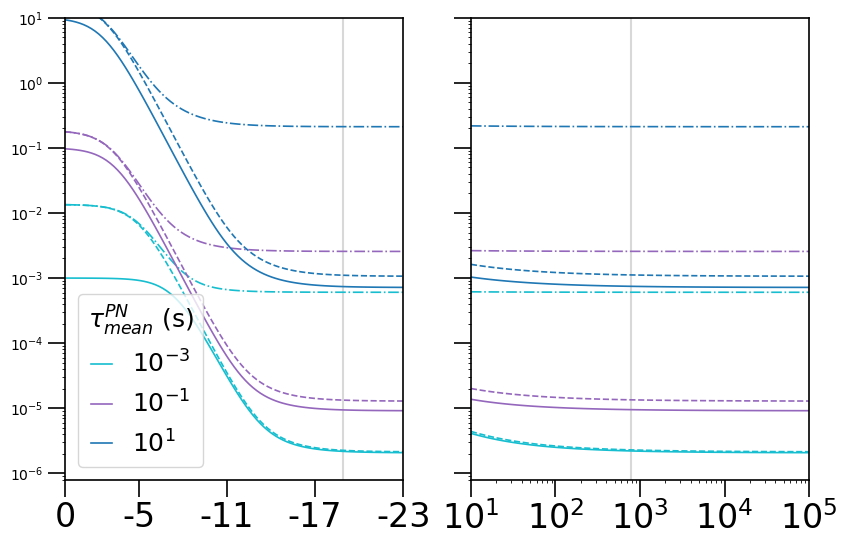

In [5]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale*1.0, 'loc':'best', 'handlelength':1.4*scale*1.0, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale*1.0}

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16*scale,10*scale))
for ax in axes:
    ax.tick_params(length=20*scale,width=2*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2*scale)  # change width

C0 = 0.6022

## plot for fixed protein concentration

parm_file = CP62nM_parm

KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

KPN_list = KPN_list[::46]
colors = colors[::46]
axes[0].axvline(np.log(1e8/C0), color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    ## for model B
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    ## for model C
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

axes[0].semilogy()
axes[0].set_xlim([0, 23])
axes[0].set_xticks(
    [0,  5, 11, 17, 23], [0, -5, -11, -17, -23], **tickfont
)
axes[0].set_ylim([0.8e-6,1e1])
# axes[0].set_yticks(
#     [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6], 
#     ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$', '$10^{6}$'], 
#     **tickfont
# )
axes[0].legend(**legend)

## plot for fixed dimerization strength

parm_file = KPP1e8_parm

KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

KPN_list = KPN_list[::46]
colors = colors[::46]
axes[1].axvline((0.01/2.1e4)*1e9/0.6022, color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    ## for model B
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    ) 
    ## for model C
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

axes[1].loglog()
axes[1].set_xlim([1e1, 1e5])
axes[1].set_xticks(
    [10**i for i in range(1,6)],
    ['$10^{%.0f}$'%i for i in range(1,6)], 
    **tickfont
)
# axes[1].legend(**legend)

plt.show()

### c) d) protein bound ratio v.s. dimerization (three models, analytical)

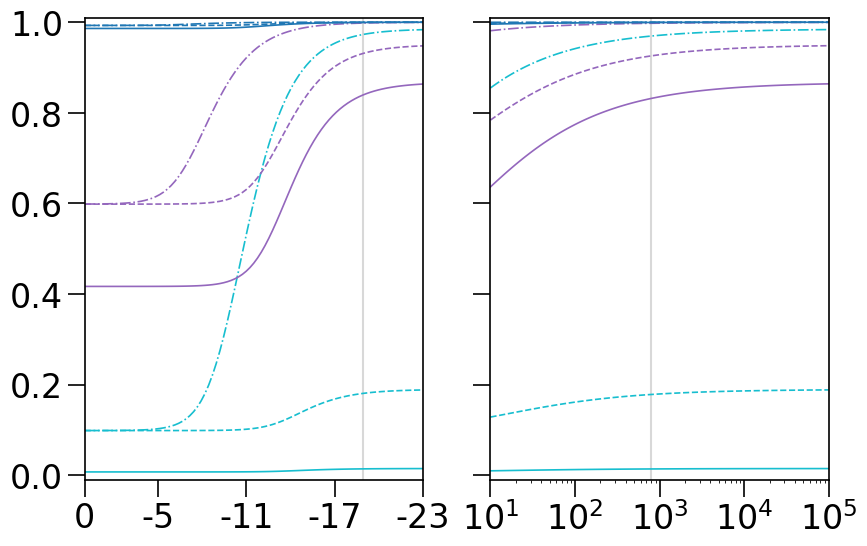

In [55]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale*1.0, 'loc':[0.6,0.23], 'handlelength':1.4*scale*1.0, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale*1.0}

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16*scale,10*scale))
for ax in axes:
    ax.tick_params(length=20*scale,width=2*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2*scale)  # change width

C0 = 0.6022

## plot for fixed protein concentration

parm_file = CP62nM_parm

KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

KPN_list = KPN_list[::46]
colors = colors[::46]
axes[0].axvline(np.log(1e8/C0), color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    # for model B
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    # for model C
    axes[0].plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

axes[0].set_xlim([0, 23])
axes[0].set_xticks(
    [0,  5, 11, 17, 23], [0, -5, -11, -17, -23], **tickfont
)
axes[0].set_ylim([-0.01,1.01])
axes[0].set_yticks(
    [(i/10) for i in range(0, 11, 2)], 
    ['%.1f'%(i/10) for i in range(0, 11, 2)], 
    **tickfont
)
# axes[0].legend(**legend)

## plot for fixed dimerization strength
parm_file = KPP1e8_parm

KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

KPN_list = KPN_list[::46]
colors = colors[::46]
axes[1].axvline((0.01/2.1e4)*1e9/0.6022, color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
    )
    ## for model B
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    ## for model C
    axes[1].plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

axes[1].semilogx()
axes[1].set_xlim([1e1, 1e5])
axes[1].set_xticks(
    [10**i for i in range(1,6)],
    ['$10^{%.0f}$'%i for i in range(1,6)], 
    **tickfont
)

plt.show()

### a)-d) Plot together

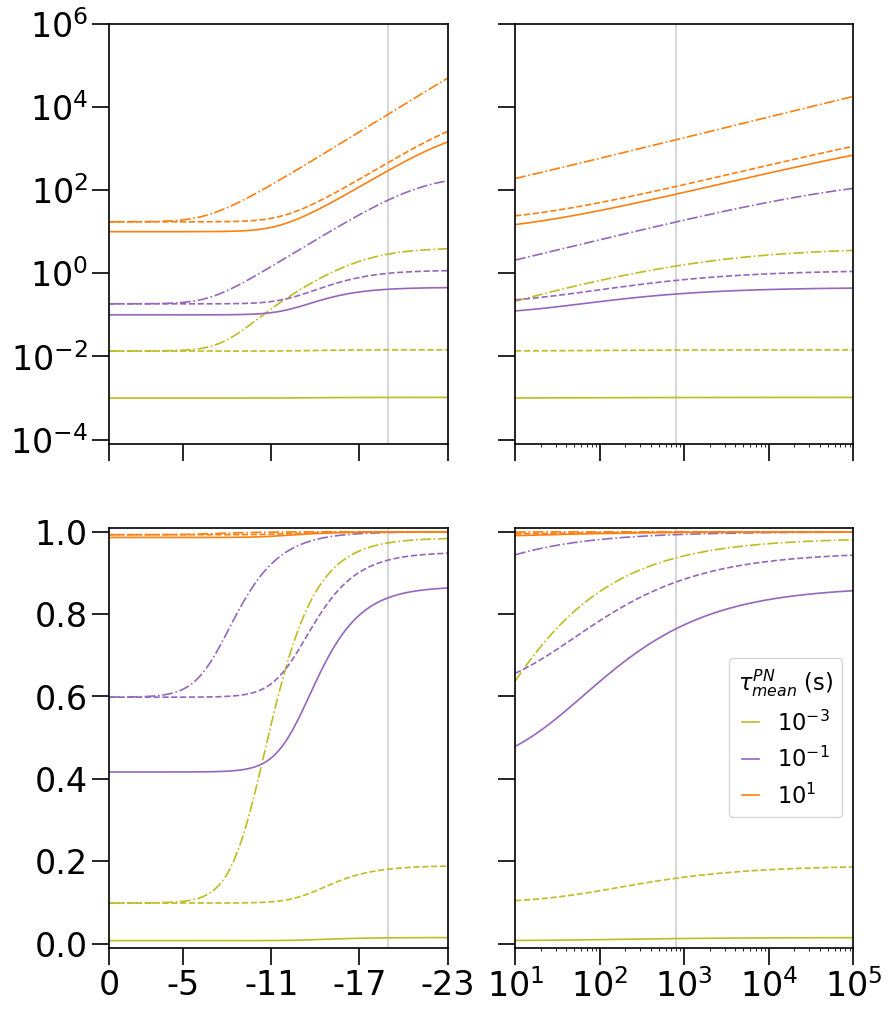

In [74]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale*0.9, 'loc':'best', 'handlelength':1.4*scale*0.9, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale*0.9}

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(16*scale,20*scale)
)
for ax_row1 in axes:
    for ax in ax_row1:
        ax.tick_params(length=20*scale,width=2*scale)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2*scale)  # change width

C0 = 0.6022

## plot for fixed protein concentration

parm_file = CP62nM_parm
KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))
KPN_list = KPN_list[1::2]
colors = colors[1::2]

ax = axes[0,0]
ax.axvline(np.log(1e8/C0), color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    ## for model B
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    ## for model C
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.resT_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

ax.semilogy()
ax.set_xlim([0, 23])
ax.set_xticks(
    [0,  5, 11, 17, 23], ['' for i in [0,  5, 11, 17, 23]], **tickfont
)
ax.set_ylim([0.8e-4,1e6])
ax.set_yticks(
    [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6], 
    ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$', '$10^{6}$'], 
    **tickfont
)

## plot for fixed dimerization strength

parm_file = KPP1e8_parm
KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))
KPN_list = KPN_list[1::2]
colors = colors[1::2]

ax = axes[0,1]
ax.axvline((0.01/2.1e4)*1e9/0.6022, color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    ## for model B
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    ) 
    ## for model C
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

ax.loglog()
ax.set_xlim([1e1, 1e5])
ax.set_xticks(
    [10**i for i in range(1,6)],
    ['' for i in range(1,6)], 
    **tickfont
)
ax.set_ylim([0.8e-4,1e6])
ax.set_yticks(
    [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6], 
    ['', '', '', '', '', ''], 
    **tickfont
)

## plot for fixed protein concentration

parm_file = CP62nM_parm
KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))
KPN_list = KPN_list[1::2]
colors = colors[1::2]

ax = axes[1,0]
ax.axvline(np.log(1e8/C0), color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    # for model B
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    # for model C
    ax.plot(
        np.log(parm_file['KPP'][KPN_select]/C0), 
        np.array(CP62nM_ana.pBound_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

ax.set_xlim([0, 23])
ax.set_xticks(
    [0,  5, 11, 17, 23], [0, -5, -11, -17, -23], **tickfont
)
ax.set_ylim([-0.01,1.01])
ax.set_yticks(
    [(i/10) for i in range(0, 11, 2)], 
    ['%.1f'%(i/10) for i in range(0, 11, 2)], 
    **tickfont
)

## plot for fixed dimerization strength
parm_file = KPP1e8_parm
KPN_list = np.unique(parm_file['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))
KPN_list = KPN_list[1::2]
colors = colors[1::2]

ax = axes[1,1]
ax.axvline((0.01/2.1e4)*1e9/0.6022, color='gray', alpha=0.3)
for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results for model A
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_Nonly)[KPN_select], 
        color=colors[i], ls='-', lw=2*scale,
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )
    ## for model B
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_singleS)[KPN_select], 
        color=colors[i], ls='--', lw=2*scale,
    )
    ## for model C
    ax.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_doubleS)[KPN_select], 
        color=colors[i], ls='-.', lw=2*scale,
    )

ax.semilogx()
ax.set_xlim([1e1, 1e5])
ax.set_xticks(
    [10**i for i in range(1,6)],
    ['$10^{%.0f}$'%i for i in range(1,6)], 
    **tickfont
)
ax.set_ylim([-0.01,1.01])
ax.set_yticks(
    [(i/10) for i in range(0, 11, 2)], 
    ['' for i in range(0, 11, 2)], 
    **tickfont
)
ax.legend(**legend)

plt.show()

## Heatmaps

In [29]:
2/2.1e4 * 1e3

0.09523809523809525

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Import numerical results
from CP62nM import analytical as CP62nM

In [2]:
CP62nM_parm = pd.read_csv('./CP62nM/parameters.csv')
C0 = 0.6022

### heatmap compare  $\tau_{mean}$ of model C with model A

In [26]:
dfCP62nM = {
    'tauPN':np.round(np.log10(1/CP62nM_parm['kbPN']), 2), 
    'lnKPP':np.round(np.log(CP62nM_parm['KPP']/C0), 2),
    'resT_Nonly':CP62nM.resT_Nonly,
    'resT_singleS':CP62nM.resT_singleS,
    'resT_doubleS':CP62nM.resT_doubleS
}
dfCP62nM = pd.DataFrame(dfCP62nM)

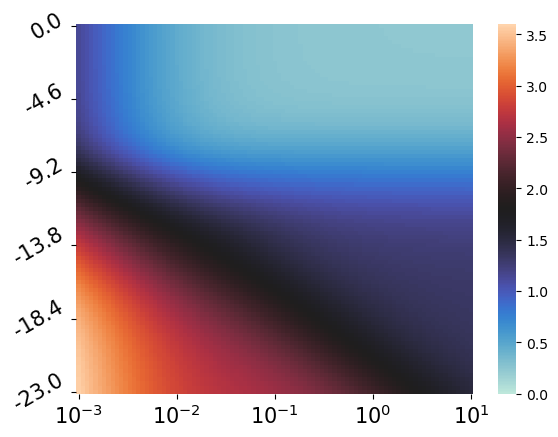

In [27]:
ax = sns.heatmap(
    np.log10(
        dfCP62nM.pivot(
            index="lnKPP", columns="tauPN", values="resT_doubleS"
        )/dfCP62nM.pivot(
            index="lnKPP", columns="tauPN", values="resT_Nonly"
        )
    ),
    vmin=0, vmax=3.6, 
    cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=23, yticklabels=18
)

xticklabels_plot = ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']
ax.set_xticks(ax.get_xticks(), xticklabels_plot, fontsize=15, rotation=0)

ax.set_yticks(
    ax.get_yticks(), 
    ['0.0', '-4.6', '-9.2', '-13.8', '-18.4', '-23.0'], 
    fontsize=15, rotation=30
)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

### heatmap compare $\theta_P$ of model C with model A

In [22]:
dfCP62nM = {
    'tauPN':np.round(np.log10(1/CP62nM_parm['kbPN']), 2), 
    'lnKPP':np.round(np.log(CP62nM_parm['KPP']/C0), 2),
    'pBoundNonly':CP62nM.pBound_Nonly,
    'pBoundSingleS':CP62nM.pBound_singleS,
    'pBoundDoubleS':CP62nM.pBound_doubleS
}
dfCP62nM = pd.DataFrame(dfCP62nM)

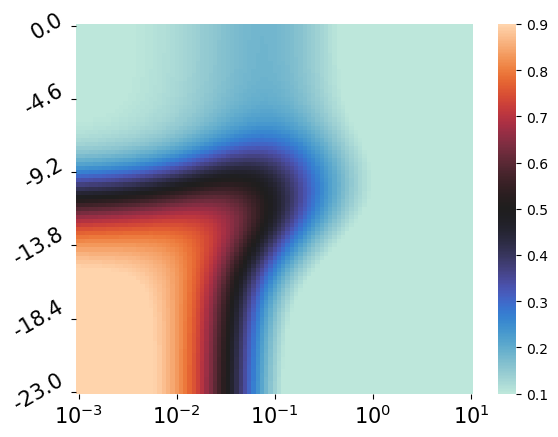

In [24]:
ax = sns.heatmap(
    ((dfCP62nM.pivot(
        index="lnKPP", columns="tauPN", values="pBoundDoubleS"
    ) - dfCP62nM.pivot(
        index="lnKPP", columns="tauPN", values="pBoundNonly"
    ))),
    vmin=0.1, vmax=0.9, 
    cmap='icefire',
    xticklabels=23, yticklabels=18
)

xticklabels_plot = ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']
ax.set_xticks(ax.get_xticks(), xticklabels_plot, fontsize=15, rotation=0)

ax.set_yticks(
    ax.get_yticks(), 
    ['0.0', '-4.6', '-9.2', '-13.8', '-18.4', '-23.0'], 
    fontsize=15, rotation=30
)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()